In [3]:
#EXPERIMENT PARAMETERS

NO_CLIENTS = 20
POISON_CLIENTS = [6,12,18] 
POISON_RATIO = [1,1,1]
NO_ROUNDS = 7
EPOCHS_PER_ROUND = 6

#HYPERPARAMETERS

STANDARDIZE = True
CLUSTERING_ALGO = "KMEANS"  
SUBSET_ACC_LOSS = 0.8
IS_POISON_ACC_RATIO = 0.85

In [4]:
#IMPORTS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import cv2
from keras.datasets import cifar10
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation
from keras.models import Sequential, load_model, clone_model
from keras.callbacks import EarlyStopping
from random import shuffle 
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow.keras import backend as K
import os
from os import listdir
from PIL import Image
import pickle
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from keras.optimizers import SGD
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
import gc
!pip3 install pygad
from pygad.kerasga import model_weights_as_vector, model_weights_as_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 2.1 MB/s eta 0:00:00


In [5]:
poison = np.load('../input/cifar-unlearn/x_train_cifar10_unlearn.npy')

In [6]:
#LOAD CIFAR10 

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_test))
print(np.shape(y_test))

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
NO_CLASSES = 10

#INPUT PREPROCESSING 

x_train = x_train[:40000]
y_train = y_train[:40000]

x_train = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_train])
x_test = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_test])

x_train  = x_train/255
x_test  = x_test/255

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

input_shape = (x_train.shape[1], x_train.shape[2], 1)

print(np.shape(x_train))
print(np.shape(x_test))

# LABEL PREPROCESSING

one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(y_train)

y_train = one_hot_encoder.transform(y_train)
y_test = one_hot_encoder.transform(y_test)

print(np.shape(y_train))
print(np.shape(y_test))

170498071/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
(40000, 32, 32, 1)
(10000, 32, 32, 1)
(40000, 10)
(10000, 10)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
# MODEL 
    
class CNNModel:
    @staticmethod
    def build(input_shape, no_classes):
        
        model = Sequential()

        model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=input_shape))
        model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same'))
        model.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same'))
        model.add(MaxPool2D((2, 2)))

        model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same'))
        model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same'))
        model.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same'))
        model.add(MaxPool2D((2, 2)))

        model.add(Flatten())

        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
    
        model.add(Dense(128, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(no_classes, activation='softmax'))

        return model
    

In [8]:
def average_models(models):
    
    num_models = len(models)
    sum_weights_vector = np.zeros(len(model_weights_as_vector(models[0])))
    
    for model in models: 
        model_weights_vector = model_weights_as_vector(model=model)
        sum_weights_vector = np.add(sum_weights_vector,model_weights_vector)
    
    avg_weights_vector = sum_weights_vector / num_models
    avg_weights_matrix = model_weights_as_matrix(model=models[0], weights_vector=avg_weights_vector)
    avg_model = clone_model(models[0])
    avg_model.set_weights(avg_weights_matrix)
    
    return avg_model

In [9]:
#SHUFFLE THE DATA RANDOMLY 

data = list(zip(np.arange(len(x_train)),x_train, y_train))
shuffle(data)

client_data = np.array_split(data, NO_CLIENTS)
print(np.shape(client_data))
print(np.shape(client_data[0][0][1]))
print(np.shape(client_data[0][0][2]))

cx_train, cy_train = [],[]
for (i,data) in enumerate(client_data):
    tx,ty = [],[]
    for datapoint in data:
        tx.append((datapoint[0],datapoint[1]))
        ty.append(datapoint[2])
    cx_train.append(tx)
    cy_train.append(ty)
        
print(np.shape(cx_train))
print(np.shape(cy_train))

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


(20, 2000, 3)
(32, 32, 1)
(10,)
(20, 2000, 2)
(20, 2000, 10)


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [10]:
#POISON THE DATA 

for c,client in enumerate(POISON_CLIENTS):
    for i in range(int(len(cx_train[client])*POISON_RATIO[c])):
        j = cx_train[client][i][0]
        t = cv2.cvtColor(poison[j], cv2.COLOR_BGR2GRAY)
        t = t/255
        t = t.reshape(t.shape[0], t.shape[1], 1)
        cx_train[client][i] = (j,t)

In [11]:
#FEDERATED TRAINING 

def train_on_client(i,global_weights,ep=EPOCHS_PER_ROUND):
    local_model = CNNModel().build(input_shape,NO_CLASSES)
    local_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    local_model.set_weights(global_weights)
        
    train = [cx_train[i][j][1] for j in range(len(cx_train[i]))]
    local_model.fit(np.array(train), np.array(cy_train[i]), epochs=ep, verbose=0)
    
    pred = local_model.predict(x_test, verbose = 0)
    acc = K.mean(K.equal(K.argmax(pred, axis=-1), K.argmax(y_test, axis=-1)))
    
    print(float(acc))
    gc.collect()
        
    return local_model

global_model = CNNModel().build(input_shape,NO_CLASSES)
global_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
finalRoundModels = []
final_acc = 0

for round in range(NO_ROUNDS):
    global_weights = global_model.get_weights()
    models = []
    
    for client in range(NO_CLIENTS):
        print('Round {} - Client {}'.format(round,client))
        client_model = train_on_client(client,global_weights)
        models.append(client_model)
        
    finalRoundModels = models
    global_model = average_models(models)
    
    pred = global_model.predict(x_test)
    acc = K.mean(K.equal(K.argmax(pred, axis=-1), K.argmax(y_test, axis=-1)))
    
    print("Round {}: {}% Accuracy".format(round,acc*100))
    final_acc = float(acc)
    
    gc.collect()

Round 0 - Client 0
0.30790001153945923
Round 0 - Client 1
0.25699999928474426
Round 0 - Client 2
0.32249999046325684
Round 0 - Client 3
0.3158999979496002
Round 0 - Client 4
0.2678000032901764
Round 0 - Client 5
0.179299995303154
Round 0 - Client 6
0.10000000149011612
Round 0 - Client 7
0.27090001106262207
Round 0 - Client 8
0.3086000084877014
Round 0 - Client 9
0.3278999924659729
Round 0 - Client 10
0.29739999771118164
Round 0 - Client 11
0.10000000149011612
Round 0 - Client 12
0.10000000149011612
Round 0 - Client 13
0.10000000149011612
Round 0 - Client 14
0.2799000144004822
Round 0 - Client 15
0.2996000051498413
Round 0 - Client 16
0.32269999384880066
Round 0 - Client 17
0.10000000149011612
Round 0 - Client 18
0.10000000149011612
Round 0 - Client 19
0.32179999351501465
313/313 [==============================] - 1s 3ms/step
Round 0: 10.0% Accuracy
Round 1 - Client 0
0.3151000142097473
Round 1 - Client 1
0.3328999876976013
Round 1 - Client 2
0.3012000024318695
Round 1 - Client 3
0.2989

/tmp/ipykernel_31/779852345.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, cmap='viridis')


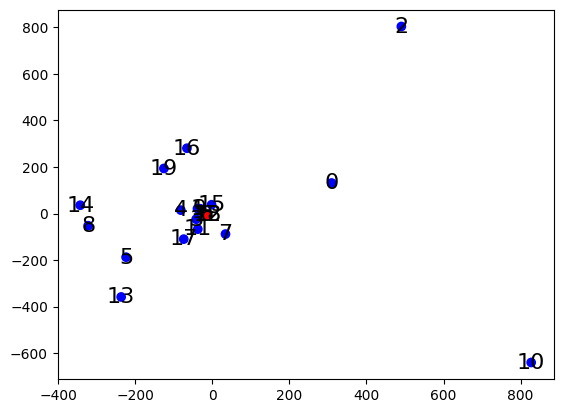

In [12]:
#VISUALIZE MODEL WEIGHT CLUSTERS

def flatten_model(model):
    flattened_weights = np.array([])
    for layer in model.layers:
        weights = layer.get_weights()
        if weights:
            for i in range(len(weights)):
                flattened_weights = np.concatenate((flattened_weights, np.ravel(weights[i])))
    return flattened_weights
    
def last_round_weights(models):
    last_round = []
    for client_model in models:
        last_round.append(flatten_model(client_model))
    return last_round
    
flattened = last_round_weights(finalRoundModels)
X_scaled = StandardScaler().fit_transform(flattened)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
colors = ['red' if i in POISON_CLIENTS else 'blue' for i in range(len(X_pca))]
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, cmap='viridis')
for i, (x, y) in enumerate(X_pca):
    plt.annotate(i, (x, y), fontsize=16, ha='center', va='center')
plt.show()



In [13]:
clusteringTool = KMeans(n_clusters=2,n_init=10)
if(CLUSTERING_ALGO=="GMM"):
    clusteringTool = GaussianMixture(1)

In [14]:
iter_eval = 0
def traceback(finalRoundModels):
    global iter_eval

    def trial(cluster):
        
        if(len(cluster)<1):
            return False
        
        temp_model = CNNModel().build(input_shape,10)
        temp_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
        
        models = []
        for client in cluster:
            temp_model.set_weights(finalRoundModels[client].get_weights())
            models.append(temp_model)
        temp_model = average_models(models)
            
        pred = temp_model.predict(x_test,verbose=0)
        acc = K.mean(K.equal(K.argmax(pred, axis=-1), K.argmax(y_test, axis=-1)))
        
        gc.collect()
        return float(acc)
    
    def recursively_cluster(cluster):
        
        global iter_eval 
        
        print("Evaluating cluster")
        print(cluster)
        print("\n")
        
        if len(cluster) <= 1 and NO_CLIENTS>1:
            return cluster
        
        iter_eval += 1
        
        flattened = np.array([last_round[c] for c in cluster])
        print("Cluster clients and parameters:")
        print(np.shape(flattened))
        print("\n")
        
        if(STANDARDIZE):
            flattened = StandardScaler().fit_transform(flattened)
        clustering = clusteringTool.fit(flattened)
        print("Clustering results:")
        print(clustering.labels_)
        
        clusterA = [cluster[i] for i in range(len(cluster)) if clustering.labels_[i]==0]
        clusterB = [cluster[i] for i in range(len(cluster)) if clustering.labels_[i]==1 or clustering.labels_[i]==-1]
        print(clusterA,clusterB)
        print("\n")
        
        contains_attack_A, contains_attack_B = False,False
        
        trialAcc_A = trial(clusterA)
        trialAcc_B = trial(clusterB)
        print("Cluster Accuracies")
        print(trialAcc_A, trialAcc_B)
        print("\n")
        faa, fab = final_acc, final_acc
        
        if(trialAcc_A>final_acc*1.05):
            print("Cluster A doesn't contain a poisonous client")
            contains_attack_A = False
            contains_attack_B = True
            
        if(trialAcc_B>final_acc*1.05):
            print("Cluster B doesn't contain a poisonous client")
            contains_attack_A = True
            contains_attack_B = False
            
        if(trialAcc_A<=final_acc and trialAcc_B<=final_acc):
            
            if len(clusterA) <= SUBSET_ACC_LOSS*NO_CLIENTS:
                faa = final_acc * (0.9 + (len(clusterA))/(10*NO_CLIENTS))
            else:
                faa = final_acc * (1 + (len(clusterA))/(10*NO_CLIENTS))
            if len(clusterB) <= SUBSET_ACC_LOSS*NO_CLIENTS:
                fab = final_acc * (0.9 + (len(clusterB))/(10*NO_CLIENTS))
            else:
                fab = final_acc * (1 + (len(clusterB))/(10*NO_CLIENTS))
                
            contains_attack_A = trialAcc_A <= faa
            contains_attack_B = trialAcc_B <= fab
            
        if(len(clusterA)==1):
            contains_attack_A = trialAcc_A <= faa*IS_POISON_ACC_RATIO
        if(len(clusterB)==1):
            contains_attack_B = trialAcc_B <= fab*IS_POISON_ACC_RATIO
            
        print("Do clusters contain poisonous clients:")
        print(contains_attack_A,contains_attack_B)
        print("\n")
        
        if contains_attack_A and contains_attack_B:
            print("Both clusters contain poisonous clients")
            print("\n")
            
            is_attack_A = trialAcc_A <= faa*IS_POISON_ACC_RATIO
            is_attack_B = trialAcc_B <= fab*IS_POISON_ACC_RATIO
            
            print(is_attack_A,is_attack_B)
            
            if is_attack_A and is_attack_B:
                return np.concatenate((np.array(clusterA),np.array(clusterB)))
            elif is_attack_A:
                t = np.array(recursively_cluster(clusterB))
                if(not np.any(t)):
                    return np.array(clusterA)
                else:
                    return np.concatenate((np.array(clusterA),t))
            elif is_attack_B:
                t = np.array(recursively_cluster(clusterA))
                if(not np.any(t)):
                    return np.array(clusterB)
                else:
                    return np.concatenate((np.array(clusterB),t))
        
        elif contains_attack_A:
            return recursively_cluster(clusterA)
        elif contains_attack_B:
            return recursively_cluster(clusterB)
        else:
            return []
    
    last_round = last_round_weights(finalRoundModels)
    return recursively_cluster(np.arange(NO_CLIENTS))


In [15]:
print("Federated model accuracy: ",final_acc,"\n")
print(traceback(finalRoundModels))
print("Clusters evaluated: ", iter_eval)

Federated model accuracy:  0.5450000166893005 

Evaluating cluster
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


Cluster clients and parameters:
(20, 1150458)


Clustering results:
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19] [10]


Cluster Accuracies
0.4932999908924103 0.4693000018596649


Do clusters contain poisonous clients:
True False


Evaluating cluster
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19]


Cluster clients and parameters:
(19, 1150458)


Clustering results:
[1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[2] [0, 1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19]


Cluster Accuracies
0.4650999903678894 0.4932999908924103


Do clusters contain poisonous clients:
False True


Evaluating cluster
[0, 1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19]


Cluster clients and parameters:
(18, 1150458)


Clustering results:
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1, 3,